In [1]:
# installments
%pip --quiet install git+https://github.com/wilson-labs/cola.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 917.8/917.8 kB 11.5 MB/s eta 0:00:00


In [2]:
![ ! -f "$HOME/data/cit-HepPh.txt" ] && wget -P ~/data https://www.andpotap.com/static/cit-HepPh.txt

--2024-05-07 05:19:52--  https://www.andpotap.com/static/cit-HepPh.txt
Resolving www.andpotap.com (www.andpotap.com)... 143.42.238.119
Connecting to www.andpotap.com (www.andpotap.com)|143.42.238.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6704722 (6.4M) [text/plain]
Saving to: ‘/root/data/cit-HepPh.txt’

cit-HepPh.txt       100%[===================>]   6.39M  11.7MB/s    in 0.5s    

2024-05-07 05:19:53 (11.7 MB/s) - ‘/root/data/cit-HepPh.txt’ saved [6704722/6704722]



In [3]:
# import modules
import os
import warnings
import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np

warnings.filterwarnings('ignore')
input_path = os.path.join(os.environ['HOME'], "data/cit-HepPh.txt")

In [4]:
# functions to preprocess the data
def load_graph_data(filepath, dtype, xnp, num_edges=-1):
    df = pd.read_csv(filepath, skiprows=4, delimiter="\t", header=None, names=["to", "from"])
    df = df[:num_edges]
    df2 = pd.read_csv(filepath, skiprows=4, delimiter="\t", header=None, names=["from", "to"])
    df2 = df2[:num_edges]
    df_undir = pd.concat((df, df2), axis=0)
    df_undir = df_undir.drop_duplicates()
    id_map = map_nodes_to_id(df_undir["from"].unique())
    N = len(id_map)
    print(f"Found {N:,d} nodes")
    for col in ["from", "to"]:
        df_undir[col] = df_undir[col].map(id_map)
    data = np.ones(shape=len(df_undir))
    row, col = np.array(df_undir["to"]), np.array(df_undir["from"])
    sparse_matrix = csr_matrix((data, (row, col)), shape=(N, N))
    out = transform_to_csr(sparse_matrix, xnp, dtype)
    data, col_ind, rowptr, shape = out
    return data, col_ind, rowptr, shape


def transform_to_csr(sparse_matrix, xnp, dtype):
    data = xnp.array(sparse_matrix.data, dtype=dtype, device=None)
    indices = xnp.array(sparse_matrix.indices, dtype=xnp.int64, device=None)
    indptr = xnp.array(sparse_matrix.indptr, dtype=xnp.int64, device=None)
    return data, indices, indptr, sparse_matrix.shape


def map_nodes_to_id(nodes):
    out = {}
    for idx in range(len(nodes)):
        out[int(nodes[idx])] = idx
    return out

In [5]:
# create sparse adjacency matrix
import torch
import cola
from cola.backends import torch_fns as xnp

num_edges = -1
dtype = torch.float64
data, col_ind, rowptr, shape = load_graph_data(input_path, dtype, xnp, num_edges)
Ad = cola.ops.Sparse(data, col_ind, rowptr, shape)

Found 34,545 nodes


Create the normalized Laplacian defined as $L=I - D^{-1/2} A D^{-1/2}$
- $D$ is the diagonal matrix
- $A$ is the adjacency matrix
- $I$ is the identity matrix

In [6]:
# create normalized Laplacian
Deg = cola.ops.Diagonal(Ad @ torch.ones((Ad.shape[0], ), dtype=dtype))
Id = cola.ops.I_like(Deg)
Lap = Id - cola.inv(cola.sqrt(Deg)) @ Ad @ cola.inv(cola.sqrt(Deg))
Lap = cola.SelfAdjoint(Lap) # SelfAdjoint annotation ensure that CoLA dispatches algorithms for this type of symmetric operator
print(f"Size of the Laplacian: {Lap.shape}")

Size of the Laplacian: (34545, 34545)


Compute the eigenvectors of the smallest eigenvalues and use those eigenvectors as an embedding of the data.

In [7]:
from sklearn.cluster import KMeans

eigvals, eigvecs = cola.eig(Lap, k=20, which="SM", alg=cola.Lanczos(max_iters=300))

In [8]:
eigvals

tensor([-2.6667e-15, -2.5253e-15, -2.9951e-16,  1.5716e-02,  2.3005e-02,
         3.2201e-02,  4.2626e-02,  4.2914e-02,  4.5332e-02,  4.5939e-02,
         5.5096e-02,  5.7384e-02,  6.2086e-02,  6.5325e-02,  6.7329e-02,
         6.9325e-02,  7.0176e-02,  7.0703e-02,  7.4464e-02,  7.5107e-02],
       dtype=torch.float64)

Use k-means to cluster points nearby as those points are related to cliques in the original graph.

In [9]:
n_clusters = 3
x_emb = eigvecs.to_dense()[:,:n_clusters]
kmeans = KMeans(n_clusters=n_clusters).fit(x_emb)

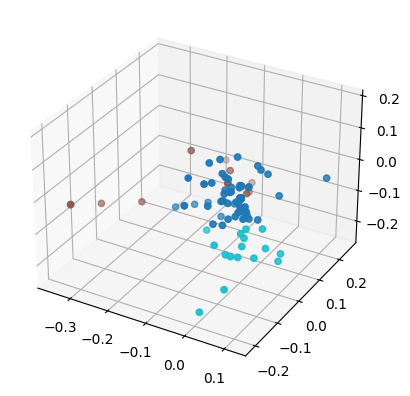

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*x_emb.T, c=kmeans.labels_, cmap="tab10")
plt.show()
